In [1]:
%%capture
# Get all hospitals for a list of countries
import pandas as pd
from utils_spatial import *

In [2]:
countries = pd.read_excel(scldatalake + 'Manuals and Standards/IADB country and area codes for statistical use/IADB_country_codes_admin_0.xlsx', engine='openpyxl')

## One country one amenity

In [28]:
amenity = ['hospital']
isoalpha3 = 'SLV'
amenities_iso = get_country_amenities(isoalpha3, amenity) 
print(len(amenities_iso))
amenities_iso.head(1)

57


,id,lon,lat,amenity,healthcare,name,wheelchair,healthcare:speciality,source,designation,emergency,helipad,opening_hours,addr:city,fixme,note,addr:street,name:es,phone
0,443211907,-89.2025771,13.7101817,hospital,hospital,Hospital Centro de Diagnóstico,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


57


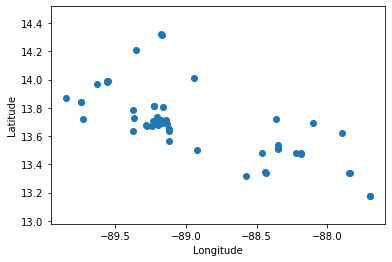

In [55]:
plot_lat_lon(amenities_iso)

In [56]:
%%capture
project_name = f'{isoalpha3}_{amenity}' 
isochrones_data = create_isochrone_analysis(data = amenities_iso, project_name=project_name,
                                            output_folder='../data', token=token, 
                                            profile='walking', time_profiles=[15, 30, 60])

UsageError: %%capture is a cell magic, but the cell body is empty.


In [75]:
plot_isochone_points(facility_data=amenities_iso, isochrones_data=isochrones_data, zoom_start=9)

## Population analysis

In [175]:
population = pd.read_csv(scldatalake + 
                         f'Development Data Partnership/Facebook - High resolution population density map/public-fb-data/csv/{isoalpha3}/{isoalpha3}_women_of_reproductive_age_15_49.csv.gz',
                        sep='\t').rename(columns={'latitude':'lat', 'longitude':'lon'})

722744


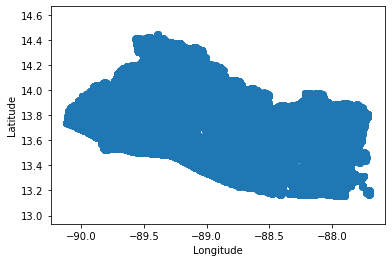

In [241]:
plot_lat_lon(population)

In [265]:
from geopandas.tools import sjoin

geom = gpd.GeoDataFrame.from_features(isochrones_data['geometry'][0])
#point = gpd.GeoDataFrame( population, geometry=gpd.points_from_xy(population.lon, population.lat))
pointInPolys = sjoin(point, geom, how='left')


In [281]:
#pointSumByPoly = pointInPolys.groupby('PolyGroupByField')['fields', 'in', 'grouped', 'output'].agg(['sum'])
#pointInPolys.amenity.value_counts(dropna=False)
pointInPolys.loc[(pointInPolys.amenity.isna()), 'amenity'] = 'False'
pointInPolys.groupby(['amenity'])['population'].agg(['sum'])

,sum
amenity,
False,1.038327e+06
hospital,1.935320e+06


In [ ]:
#!pip install swifter
import swifter
def contained_isochrone_m(x, geom):
    # Multypolygon
    query = sum([g.contains(Point(x['lat'], x['lon'])) for g  in geom])
    if query>0:
        return True
    else:
        return False
def contained_isochrone(x, geom):
    # Multypolygon
    return shape(Point(x['lat'], x['lon'])).within(shape(geom))

for minute in isochrones_data.minutes:
    geom = isochrones_data[isochrones_data.minutes==each]['geometry_2'].values[0]
    population[f'geom_{minute}'] = population.swifter.apply(contained_isochrone,geom=geom, axis=1)

In [235]:
m = folium.Map(location=[lat_mean,lon_mean], zoom_start=1, tiles='CartoDB positron')
folium.GeoJson(data=geom).add_to(m)
#m

In [259]:
population.geom_60.value_counts()

False    5
Name: geom_60, dtype: int64

In [254]:
population.assign(
    geom_60 = population['geom_60'] * population['population'],
    geom_30 = population['geom_30'] * population['population'],
    geom_15 = population['geom_15'] * population['population']
).sum(axis=0)

lat           9.902130e+06
lon          -6.425208e+07
population    1.651601e+06
geom_60       0.000000e+00
geom_30       0.000000e+00
geom_15       0.000000e+00
dtype: float64

In [ ]:
from shapely import wkt
from shapely.geometry import mapping, shape

#isochrones_data['geometry_2'] = isochrones_data['geometry'].apply(gpd.GeoDataFrame.from_features).apply(lambda x: x.unary_union)
#gpd.GeoDataFrame.from_features(isochrones_data['geometry'][0]).unary_union
for each in isochrones_data.minutes:
    geom = isochrones_data[isochrones_data.minutes==each]['geometry_2'].values[0]
    for index, row in population.iterrows():
        population.loc[index, f'geom_{each}'] = geom.contains(Point(row['lat'], row['lon']))    